# Problem

Problem Statement: Predict future energy consumption patterns based on correlating factors such as temperature, rainfall, and humidity.

In order to do this we will utilize weather and consumption data from 2015 to 2018.

The goal is to be able to predict the energy consumption better than the predicted energy consumption in the dataset.

# Data exploartion

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
import keras
from tensorflow.keras.optimizers import Adam

## Size and quality of data

Firstly we want to look at the size and quality of the data we have in our dataset. 
This is done by loading the data in pandas dataframes and looking for missing values. 

In [44]:
energy_df = pd.read_csv('energy_dataset.csv')
weather_df = pd.read_csv('weather_features.csv')

In [45]:
print(energy_df.shape)
print(weather_df.shape)

(35064, 29)
(178396, 17)


As we can see the two dataframes have a lot of rows. We can also see that the weather dataframe is larger than the enegy dataframe. 

In [46]:
energy_df

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 19:00:00+01:00,297.0,0.0,0.0,7634.0,2628.0,178.0,0.0,0.0,0.0,...,277.0,0.0,3113.0,96.0,NaN,3253.0,30619.0,30653.0,68.85,77.02
35060,2018-12-31 20:00:00+01:00,296.0,0.0,0.0,7241.0,2566.0,174.0,0.0,0.0,0.0,...,280.0,0.0,3288.0,51.0,NaN,3353.0,29932.0,29735.0,68.40,76.16
35061,2018-12-31 21:00:00+01:00,292.0,0.0,0.0,7025.0,2422.0,168.0,0.0,0.0,0.0,...,286.0,0.0,3503.0,36.0,NaN,3404.0,27903.0,28071.0,66.88,74.30
35062,2018-12-31 22:00:00+01:00,293.0,0.0,0.0,6562.0,2293.0,163.0,0.0,0.0,0.0,...,287.0,0.0,3586.0,29.0,NaN,3273.0,25450.0,25801.0,63.93,69.89


It can be observed that the energy dataframe contanins many zeros and NaNs. We check wethere some of the rows only contain zero as null, as these will not be useful for predictions. 

In [47]:
for column in energy_df:
    all_zeros_or_null = (energy_df[column] == 0) | pd.isnull(energy_df[column])
    print(column, ": ", all_zeros_or_null.all())

time :  False
generation biomass :  False
generation fossil brown coal/lignite :  False
generation fossil coal-derived gas :  True
generation fossil gas :  False
generation fossil hard coal :  False
generation fossil oil :  False
generation fossil oil shale :  True
generation fossil peat :  True
generation geothermal :  True
generation hydro pumped storage aggregated :  True
generation hydro pumped storage consumption :  False
generation hydro run-of-river and poundage :  False
generation hydro water reservoir :  False
generation marine :  True
generation nuclear :  False
generation other :  False
generation other renewable :  False
generation solar :  False
generation waste :  False
generation wind offshore :  True
generation wind onshore :  False
forecast solar day ahead :  False
forecast wind offshore eday ahead :  True
forecast wind onshore day ahead :  False
total load forecast :  False
total load actual :  False
price day ahead :  False
price actual :  False


It is observed that multiple columns include only zero or null. These columns are removed before further exploration. 

In [48]:
def check_all_zero(df):
    all_zero_column=[]
    for column in energy_df:
        all_zeros_or_null = (energy_df[column] == 0) | pd.isnull(energy_df[column])
        if all_zeros_or_null.all()==True:
            all_zero_column.append(column)
    return all_zero_column

In [49]:
all_zero_column = check_all_zero(energy_df)
energy_df_0 = energy_df.drop(all_zero_column, axis=1)
energy_df_0.shape

(35064, 21)

Combine the two dataframes in order to utilize both data. ??? should we do this?

## Distribution of total laod actual by month, weakday and hour
As our goal is to predict the total load actual we will firstly focus on the distribution of this attribute based on month, weakday and hour. This also makes it so that we do not need to focus on all the attributes in the beginning

In [50]:
def pre_process_totalload(df):  
    df["time"] = pd.to_datetime(df["time"] ,utc=True)

    df.set_index('time', inplace=True)
    total_load_df = df[["total load actual"]]

    total_load_df["month"]= df.index.month
    total_load_df["weekday"]= df.index.weekday
    total_load_df["hour"]= df.index.hour
    return total_load_df
total_load_df = pre_process_totalload(energy_df_0)
total_load_df

/var/folders/5c/kj6yt0yn1tlgdrljzqyqr5jc0000gn/T/ipykernel_77385/2171150138.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_load_df["month"]= df.index.month
/var/folders/5c/kj6yt0yn1tlgdrljzqyqr5jc0000gn/T/ipykernel_77385/2171150138.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_load_df["weekday"]= df.index.weekday
/var/folders/5c/kj6yt0yn1tlgdrljzqyqr5jc0000gn/T/ipykernel_77385/2171150138.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


,total load actual,month,weekday,hour
time,,,,
2014-12-31 23:00:00+00:00,25385.0,12,2,23
2015-01-01 00:00:00+00:00,24382.0,1,3,0
2015-01-01 01:00:00+00:00,22734.0,1,3,1
2015-01-01 02:00:00+00:00,21286.0,1,3,2
2015-01-01 03:00:00+00:00,20264.0,1,3,3
...,...,...,...,...
2018-12-31 18:00:00+00:00,30653.0,12,0,18
2018-12-31 19:00:00+00:00,29735.0,12,0,19
2018-12-31 20:00:00+00:00,28071.0,12,0,20


Make boxplots for each, meaning month, weakday and hour. 

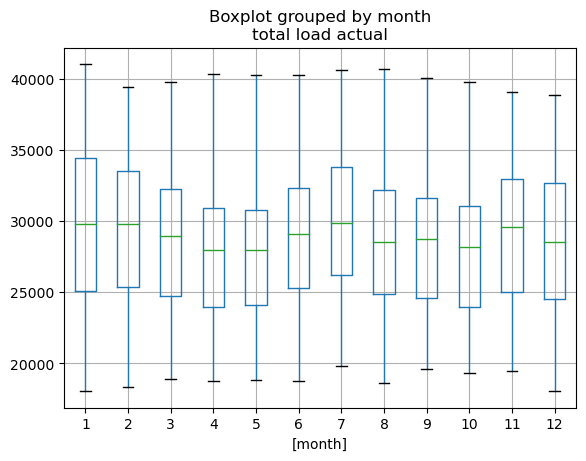

In [51]:
total_load_df[['month', 'total load actual']].boxplot(by='month');

We can see that there is a correlation between the seasons and the power consumption. this means that in the winte time (january, february, november and december) and the summer time (june, july and august) the power consumption is larger than in the spring an autumn. This makes sense due to the extreme temprature, cold and hot respectivly.

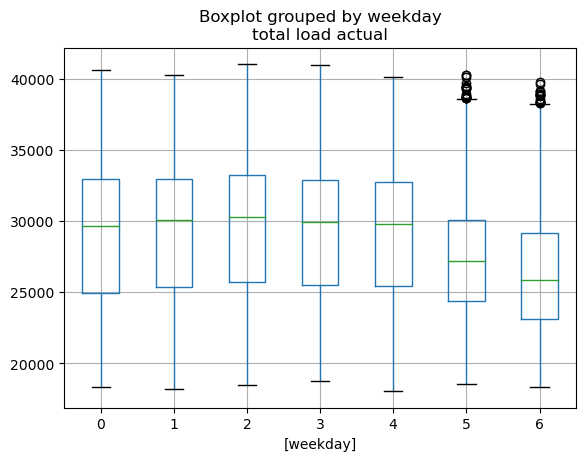

In [52]:
total_load_df[['weekday', 'total load actual']].boxplot(by='weekday');

There is a pattern where the consumption is lower in the weekends than in in the weekdays. This points to the fact that businessess are not open on the weekends, and therfore use less power. Still there are more outliers in the weekends, which needs to be taken into account. 

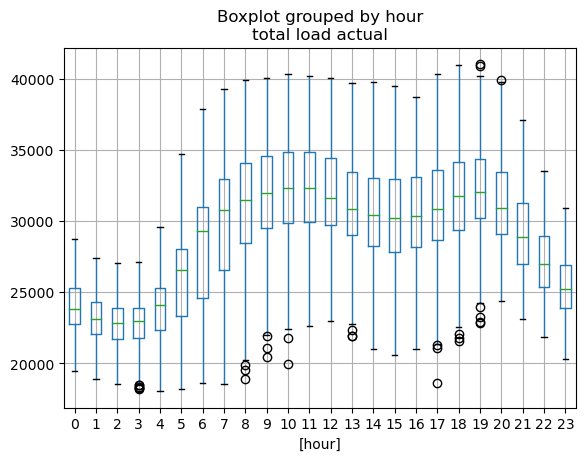

In [53]:
total_load_df[['hour', 'total load actual']].boxplot(by='hour');

It is clear that there is used leess power in the night than in daytime, and furthermore there are peaks around 10 and 18.

We did more here !!!!!!

In [54]:
def distribution_type(data, bins):
    bin_labels = [f"{int(interval.left)}-{int(interval.right)}" for interval in bins]

    # Use pandas.cut to assign each 'total load actual' value to a bin
    # Use 'loc' to avoid SettingWithCopyWarning
    data.loc[:, 'load_bin'] = pd.cut(data['total load actual'], bins=bins, labels=bin_labels)

    # Count the number of occurrences in each bin
    load_distribution = data['load_bin'].value_counts(sort=False).sort_index()

    # Plot the distribution of 'total load actual' values in a bar chart
    fig, ax = plt.subplots(figsize=(10, 4))
    load_distribution.plot(kind='bar', ax=ax)

    # Set the x-axis and y-axis labels
    ax.set_xlabel('Total Load Actual Bins')
    ax.set_ylabel('Count')

    # Show the plot
    plt.show()

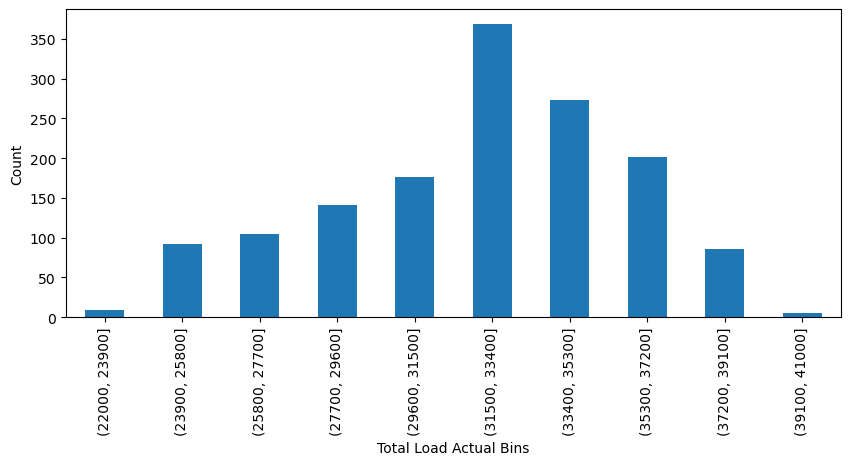

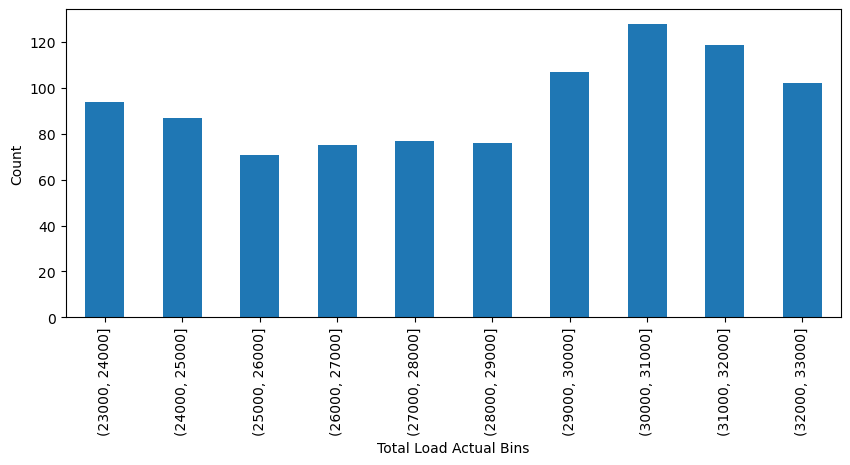

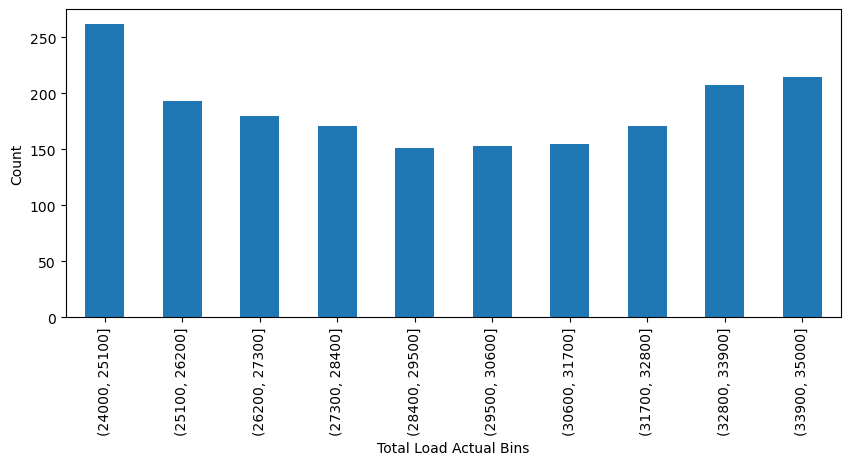

In [55]:

# Assuming total_load_df is already defined and has a DateTimeIndex

# Filter to include only entries at 10:00 AM
ten_am_load = total_load_df[total_load_df.index.hour == 10].copy()  # Make a copy to avoid the warning

# Define the range and bins for 'total load actual' values
bins = pd.interval_range(start=22000, end=41000, periods=10)

distribution_type(ten_am_load, bins)

#day
day_2= total_load_df[total_load_df.index.day == 6].copy()
bins = pd.interval_range(start=23000, end=33000, periods=10)
distribution_type(day_2, bins)

#month
month = total_load_df[total_load_df.index.month == 1].copy()
bins = pd.interval_range(start=24000, end=35000, periods=10)
distribution_type(month, bins)

It is hard to now exactly what kind of distribution the data have, but we will assume normal distribution further. 

## Linear and polynomial regression

We utilize the theory of occam's razor, and therfore start with the simplest regression model we could think of for regression problems. Namly linear and polynomial regression. 

In [56]:
## Karan could you put this in?

# Neuroprobabilistic model

As we can see the results are not very good. We therfore look at using other methods. As the data containts a lot of uncertainty, we want to utlize a neuroprobabilistic model. We therfore need to now what kind of distribution the data has. As we saw above we can assume that the data has a normal distirbution. 

In order to use the data for training we want the hours to be one-hot-encoded instead of being between 0-24.

In [57]:

total_load_df = pd.get_dummies(total_load_df, columns=['hour'], dtype=int)
total_load_df

,total load actual,month,weekday,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,25385.0,12,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2015-01-01 00:00:00+00:00,24382.0,1,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 01:00:00+00:00,22734.0,1,3,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 02:00:00+00:00,21286.0,1,3,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 03:00:00+00:00,20264.0,1,3,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,30653.0,12,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2018-12-31 19:00:00+00:00,29735.0,12,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2018-12-31 20:00:00+00:00,28071.0,12,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Partitioning into training and test set. As we are utilizing a neural network the input features needs to normalized. This is in order for the gradient desent algorithm to find the minimum point. 
(Have not normalized the target variable)

In [58]:
total_load_df = total_load_df.dropna()
y_df=total_load_df["total load actual"].astype('float64')
X_df=total_load_df.drop("total load actual", axis=1)

#sep = '2018-01-01'
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_df, test_size=0.33, random_state=42)
input_shape=len(X_df.columns)
energy_df_2 = energy_df.dropna(subset=["total load actual"])

# Normalize target variable
mean_y_train = y_train.mean()
std_y_train = y_train.std()
y_train_normalized = (y_train - mean_y_train) / std_y_train

sep = '2018-01-01'
mean_train = y_train.mean()
std_train = y_train.std()

y_train_normalized = (y_train - mean_train) / std_train
y_test_normalized = (y_test - mean_train) / std_train


In [59]:
#Seperate training and test set
# sep = '2018-01-01'
# X_train = X_df[X_df.index < sep]
# y_train = y_df[y_df.index < sep]
# X_test = X_df[X_df.index >= sep]
# y_test= y_df[y_df.index >= sep]

We add total load forecast to be used as a baseline for evaluating the model. 

In [60]:
# total_load_forecast_train = energy_df_2[X_df.index < sep]["total load forecast"]
# total_load_forecast_test = energy_df_2[X_df.index >= sep]["total load forecast"]

In [61]:
# Normalize features
X_scaled = scaler.fit_transform(X_df)

Create model

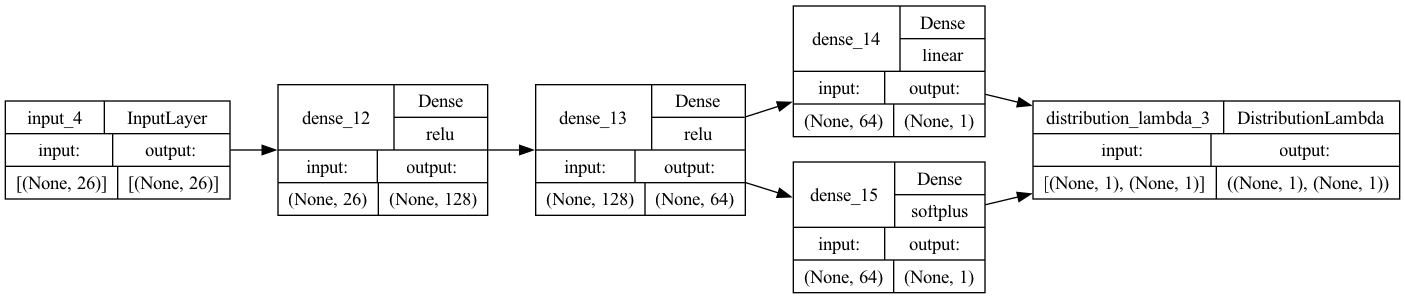

In [62]:
def build_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = Dense(128, activation='relu')(inputs)
    x = Dense(64, activation='relu')(x)
    mu = Dense(1)(x)
    sigma = Dense(1, activation=tf.nn.softplus)(x)
    outputs = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc=t[0], scale=t[1]))([mu, sigma])
    return Model(inputs, outputs)

model = build_model(X_train.shape[1])
keras.utils.plot_model(model, show_shapes=True,show_layer_names=True, rankdir='LR', show_layer_activations=True)

### Training the model

The loss function you are using is the negative log-likelihood (negloglik), which is a common choice for probabilistic models. This function calculates the log probability of the true values according to the predicted distribution and then takes the negative of this value. In probabilistic modeling, the goal is to maximize the log probability of the observed data under the model. Since most optimization algorithms (like gradient descent) are designed to minimize a function, we take the negative of the log-likelihood to turn our maximization problem into a minimization one.

So, a more negative loss means that the model's predicted distribution is getting closer to the true data distribution. This is a good sign that your model is learning. As the model trains and becomes better at predicting the true data distribution, you should expect the negative log-likelihood to decrease (become more negative).

In [63]:
negloglikelihood = lambda y_true, dist: -dist.log_prob(y_true)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss=negloglikelihood)

# Train model
history = model.fit(X_train, y_train_normalized, epochs=200, batch_size=100, verbose=1)

Epoch 1/200
235/235 [==============================] - 0s 853us/step - loss: 0.9974
Epoch 2/200
235/235 [==============================] - 0s 1ms/step - loss: 0.8924
Epoch 3/200
235/235 [==============================] - 0s 1ms/step - loss: 0.8729
Epoch 4/200
235/235 [==============================] - 0s 742us/step - loss: 0.8587
Epoch 5/200
235/235 [==============================] - 0s 744us/step - loss: 0.8534
Epoch 6/200
235/235 [==============================] - 0s 781us/step - loss: 0.8461
Epoch 7/200
235/235 [==============================] - 0s 2ms/step - loss: 0.8429
Epoch 8/200
235/235 [==============================] - 0s 850us/step - loss: 0.8378
Epoch 9/200
235/235 [==============================] - 0s 757us/step - loss: 0.8333
Epoch 10/200
235/235 [==============================] - 0s 661us/step - loss: 0.8310
Epoch 11/200
235/235 [==============================] - 0s 836us/step - loss: 0.8268
Epoch 12/200
235/235 [==============================] - 0s 712us/step - loss: 0.

In [64]:
from tensorflow.keras.metrics import MeanSquaredError

# Predict on the test set using the model
distribution_predictions = model.predict(X_test)


# We take the mean of the distribution for point predictions
point_predictions = distribution_predictions.mean()

# Initialize the MSE metric
mse = MeanSquaredError()

# Update state of the metric with true values and predicted values
mse.update_state(y_test_normalized, point_predictions)

# Calculate MSE
mean_squared_error = mse.result().numpy()

print(f"Mean Squared Error on the test set: {mean_squared_error}")


362/362 [==============================] - 0s 329us/step
Mean Squared Error on the test set: 1.0187839269638062


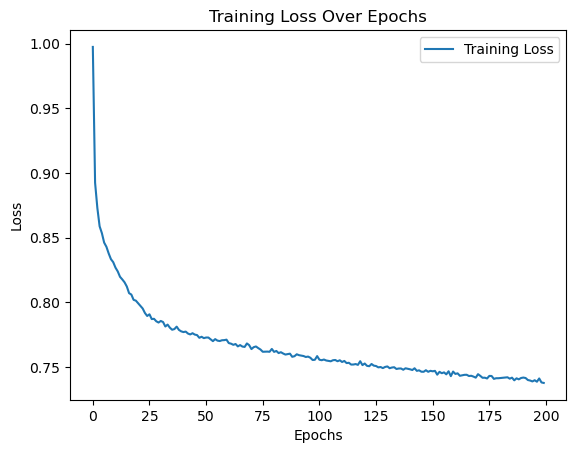

In [65]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

116/362 [========>.....................] - ETA: 0s

362/362 [==============================] - 0s 346us/step


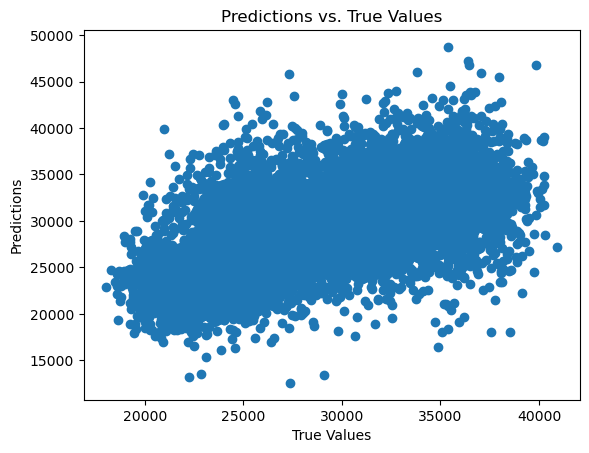

[[32556.453]
 [36067.598]
 [19255.129]
 ...
 [39825.61 ]
 [22253.775]
 [26865.207]]


In [66]:
predictions = model.predict(X_test)
# Apply inverse transformation to bring predictions back to original scale
predictions = predictions * std_train + mean_train

# Plot predictions vs. targets
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs. True Values')
plt.show()
#util.plot_pred_scatter(y_test, ts_pred, figsize=figsize)
print(predictions)

In [67]:
# Create a DataFrame with the index of X_test
result_df = pd.DataFrame(index=y_test.index)

# Add columns for predictions and true values
result_df['predictions'] = predictions.flatten()  # Flatten the predictions array
result_df['true_values'] = y_test.values #

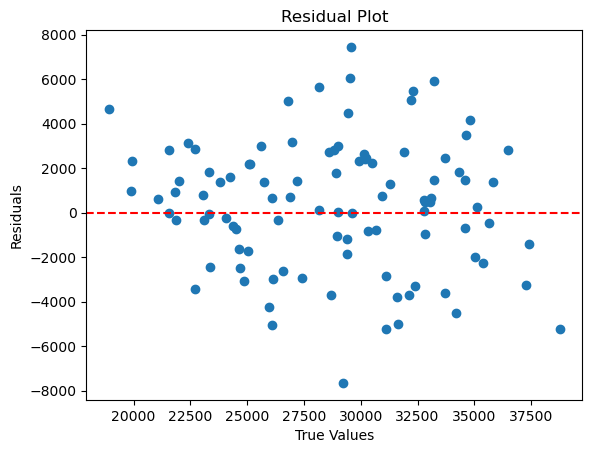

In [68]:

residuals = result_df[0:100]['predictions'] -result_df[0:100]["true_values"]
plt.scatter(result_df[0:100]["true_values"], residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

This works very badly, do we need to use more data?